In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import plotly.express as px
import seaborn as sns
import unidecode
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob
from wordcloud import STOPWORDS, WordCloud
import time

# Data Understanding

In [2]:
train_df = pd.read_csv(
    "dataset/train.csv",
    header=None
)
test_df = pd.read_csv(
    "dataset/test.csv",
    header=None
)

train_df.columns = test_df.columns = ["rating", "review"]

In [3]:
train_df.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [4]:
test_df.head()

,rating,review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [5]:
train_df["rating"].value_counts()

1    280000
2    280000
Name: rating, dtype: int64

#### There are total 560,000 records in Training dataset.

In [6]:
test_df["rating"].value_counts()

2    19000
1    19000
Name: rating, dtype: int64

#### There are total 38,000 records in Training dataset.

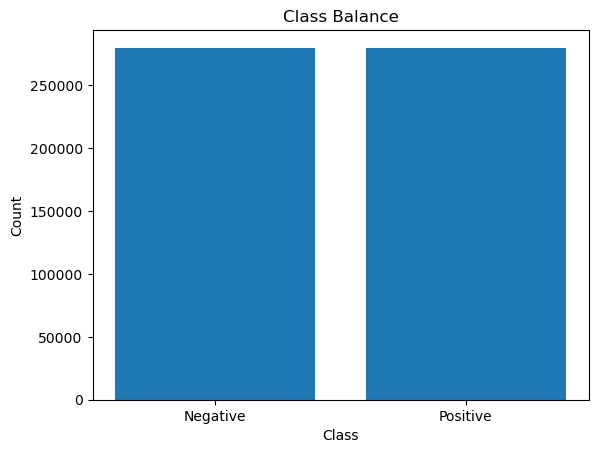

In [7]:
unique, count = np.unique(train_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

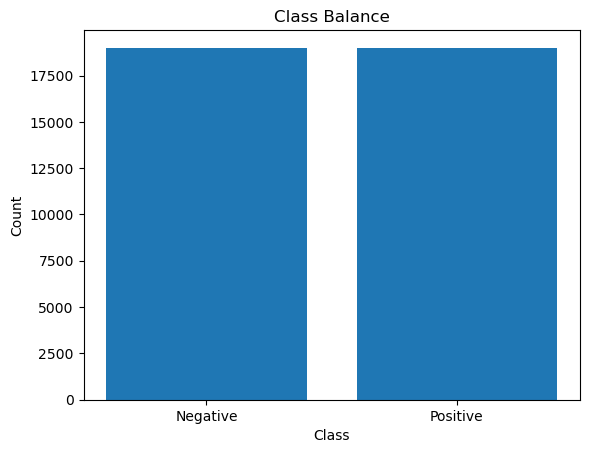

In [8]:
unique, count = np.unique(test_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

## Both above bar plots show that target variable 'rating' is well balanced with equal number of records for both positive and negative sentiments.

# No actions required to balance dataset to build better model.

In [9]:
def find_special_chars(sentence):
    """Function to find if a sentence contains any special chars.
    Returns 0 if no special chars are found and 1 if found.
    """
    spec_regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    if(spec_regex.search(sentence) == None):
        return 0
    return 1
    
special_count = 0
for review in train_df.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} out of {len(train_df.review)}")

Reviews with special characters: 410217 out of 560000


In [10]:
def contains_shorthand(sentence):
    """Function to find if a sentence contain any shorthand
    Return 1 if yes else no.
    """
    if "'" in sentence:
        return 1
    return 0
    
shorthand_count = 0
for review in train_df.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} out of {len(train_df.review)}")

Reviews with shorthands: 394763 out of 560000


In [11]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

def contains_stopwords(sentence, stopwords_list):
    """Function to find if a sentence contain any stopwords
    Return 1 if yes else 0.
    """
    for word in sentence.split(" "):
        if word.strip() in stopwords_list:
            return 1
    return 0

stopwords_count = 0
for review in train_df.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} out of {len(train_df.review)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddurgoji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reviews with stopwords: 556099 out of 560000


In [12]:
def contains_link(sentence):
    """Function to find if a sentence contain any http(s) link(s)
    Returns 1 if yes else no.
    """
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(url_regex, sentence)
    if url:
        return 1
    return 0

links_count = 0
for review in train_df.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} out of {len(train_df.review)}")

Reviews with http(s) links: 2501 out of 560000


# Data preparation

In [13]:
train_df_fixed = train_df.copy(deep=True)

def case_convert():
    """Function to convert all letters to lower case
    """
    train_df_fixed.review = [i.lower()
                             for i in train_df_fixed.review.values]

def remove_special_chars():
    """Function to remove special characters
    """
    train_df_fixed.review = [re.sub(r"[^a-zA-Z]"," ",text)
                             for text in train_df_fixed.review.values]
    
def remove_stopwords():
    """Function to remove stop words
    """
    reviews = []
    stopwords_list = stopwords.words('english')
    for item in train_df_fixed.review.values:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        reviews.append(string)
    train_df_fixed.review = reviews
        
def remove_links():
    """Function to remove http(s)links
    """
    reviews = []
    for review in train_df_fixed.review.values:
        remove_https = re.sub(r'http\S+', '', review)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        reviews.append(remove_com)
    train_df_fixed.review = reviews

def remove_accents():
    """Function to remove accents from reviews
    """
    train_df_fixed.review = [unidecode.unidecode(review)
                             for review in train_df_fixed.review.values]

def normalize_spaces():
    """Function to normalize spaces
    """
    train_df_fixed.review = [re.sub(r"\s+"," ", review)
                             for review in train_df_fixed.review.values]
    
def remove_shorthands():
    """Function to remove short hands in reviews
    """
    CONTRACTION_MAP = {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    reviews = []
    for review in train_df_fixed.review.values:
        string = ""
        for word in review.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        reviews.append(string.strip())
    train_df_fixed.review = reviews

In [14]:
case_convert()
remove_links()
remove_shorthands()
remove_accents()
remove_special_chars()
remove_stopwords()
normalize_spaces()

In [15]:
train_df_fixed

,rating,review
0,1,unfortunately frustration dr goldberg patient...
1,2,going dr goldberg years think one st patients...
2,1,know dr goldberg like moving arizona let tell...
3,1,writing review give heads see doctor office s...
4,2,food great best thing wings wings simply fant...
...,...,...
559995,2,ryan good everyone yelp claimed courteous kno...
559996,2,professional nfriendly non time affordable nw...
559997,1,phone calls always go voicemail messages retu...
559998,1,looks like good reviews gone head place jason...


In [16]:
links_count = 0
for review in train_df_fixed.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} "
      f"out of {len(train_df_fixed.review)}")

stopwords_count = 0
for review in train_df_fixed.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} "
      f"out of {len(train_df_fixed.review)}")

shorthand_count = 0
for review in train_df_fixed.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} "
      f"out of {len(train_df_fixed.review)}")

special_count = 0
for review in train_df_fixed.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} "
      f"out of {len(train_df_fixed.review)}")

Reviews with http(s) links: 0 out of 560000
Reviews with stopwords: 0 out of 560000
Reviews with shorthands: 0 out of 560000
Reviews with special characters: 0 out of 560000


## All special characters, Stop words, Short hands, HTTP(S) links etc. are removed

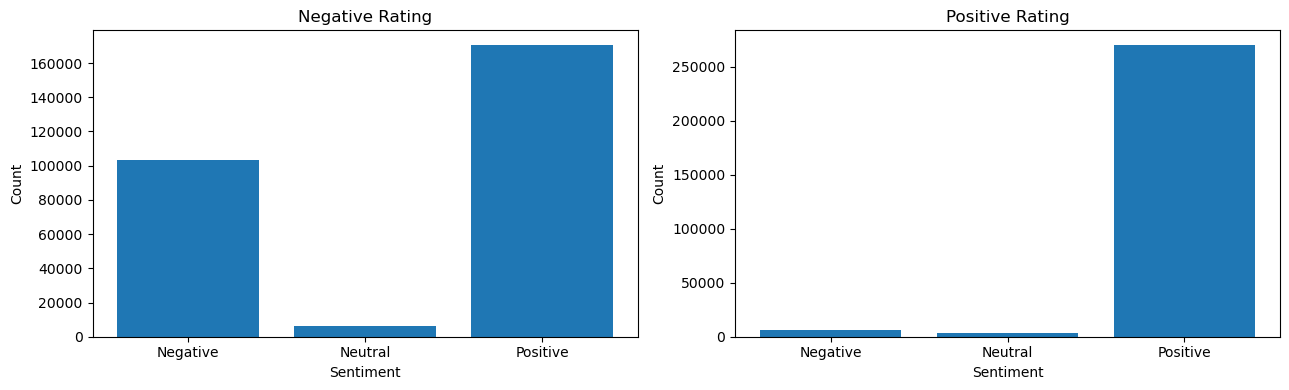

In [17]:
sentiment = []
for text in train_df_fixed.review.values:
    polarity = TextBlob(text).sentiment.polarity
    if polarity < 0:
        sentiment.append("Negative")
    elif polarity == 0:
        sentiment.append("Neutral")
    else:
        sentiment.append("Positive")
train_df_fixed["sentiment"] = sentiment
del sentiment

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
un, count = np.unique(
    train_df_fixed[train_df_fixed.rating == 1].sentiment,
    return_counts=True
)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Negative Rating")
plt.subplot(1,2,2)
un, count = np.unique(
    train_df_fixed[train_df_fixed.rating == 2].sentiment,
    return_counts=True
)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Positive Rating")
plt.tight_layout()

* First plot shows that Negative rating reviews have majority of positive sentiment than negative.
* Second plot shows that Positive rating reviews have majority positive sentiment reviews.
* Neutral sentiment reviews are very low in both plots

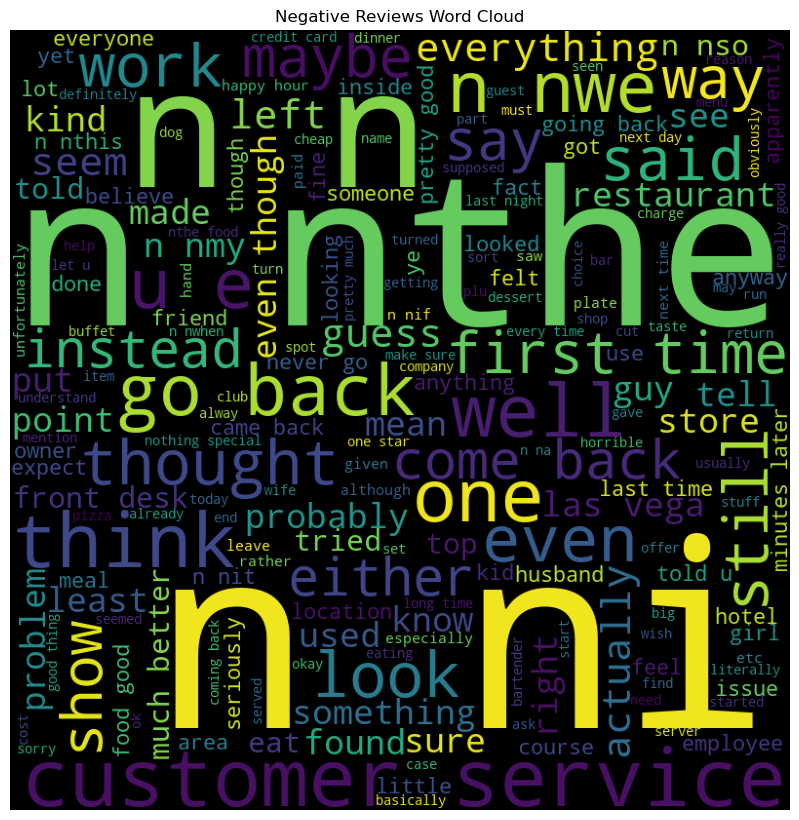

In [18]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 1].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='black',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.tight_layout(pad = 0)
 
plt.show()
del string

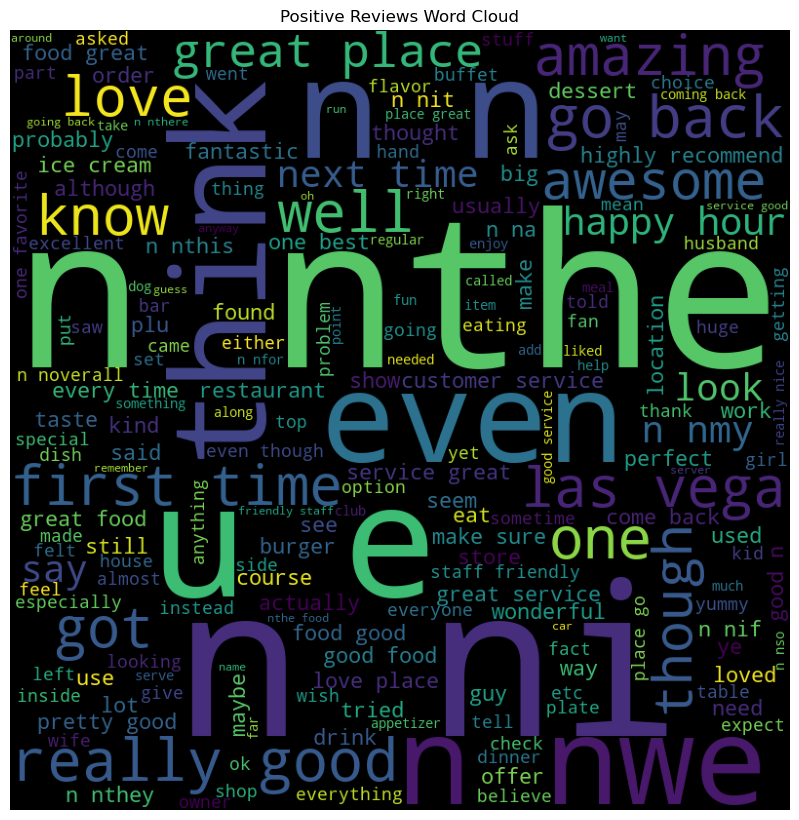

In [19]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 2].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='black',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.tight_layout(pad = 0)
 
plt.show()
del string

<Axes: xlabel='rating', ylabel='text_length'>

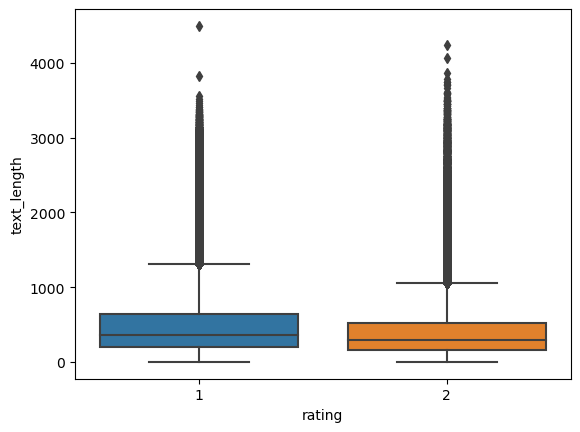

In [20]:
train_df_fixed['text_length'] = train_df_fixed['review'].apply(len)
sns.boxplot(x='rating', y='text_length', data=train_df_fixed)

## Above plot shows that for both positive and negative classes review text length is almost similar. 

Text(0, 0.5, 'count of reviews')

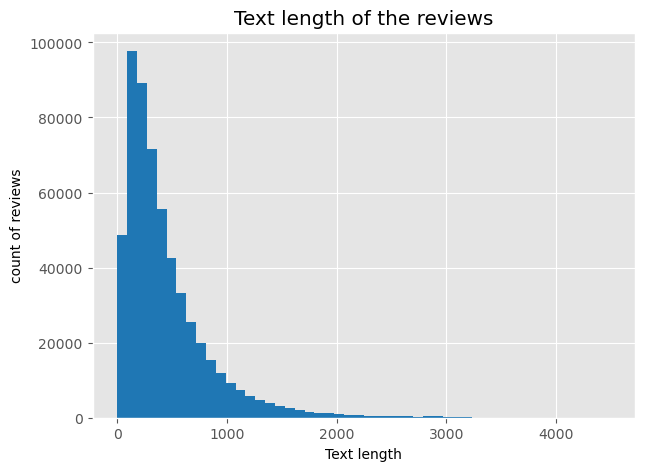

In [21]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,5))
plt.hist(train_df_fixed['text_length'], bins=50, color = "tab:blue")
ax.set_title("Text length of the reviews")
ax.set_xlabel("Text length")
ax.set_ylabel("count of reviews")

Text(0, 0.5, 'count of reviews')

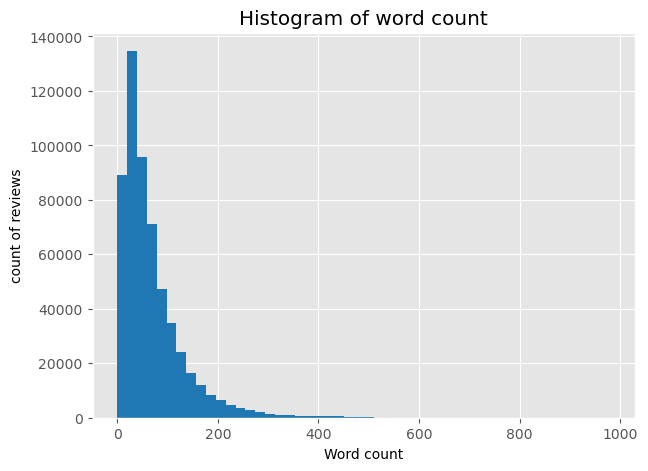

In [22]:
train_df_fixed["word_count"] = train_df_fixed["review"].apply(lambda x: len(str(x).split()))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,5))
plt.hist(train_df_fixed['word_count'], bins=50, color = "tab:blue")
ax.set_title("Histogram of word count")
ax.set_xlabel("Word count")
ax.set_ylabel("count of reviews")

### Most of the reviews are in range of 50-200 word count.

Text(0, 0.5, 'Unigram word count')

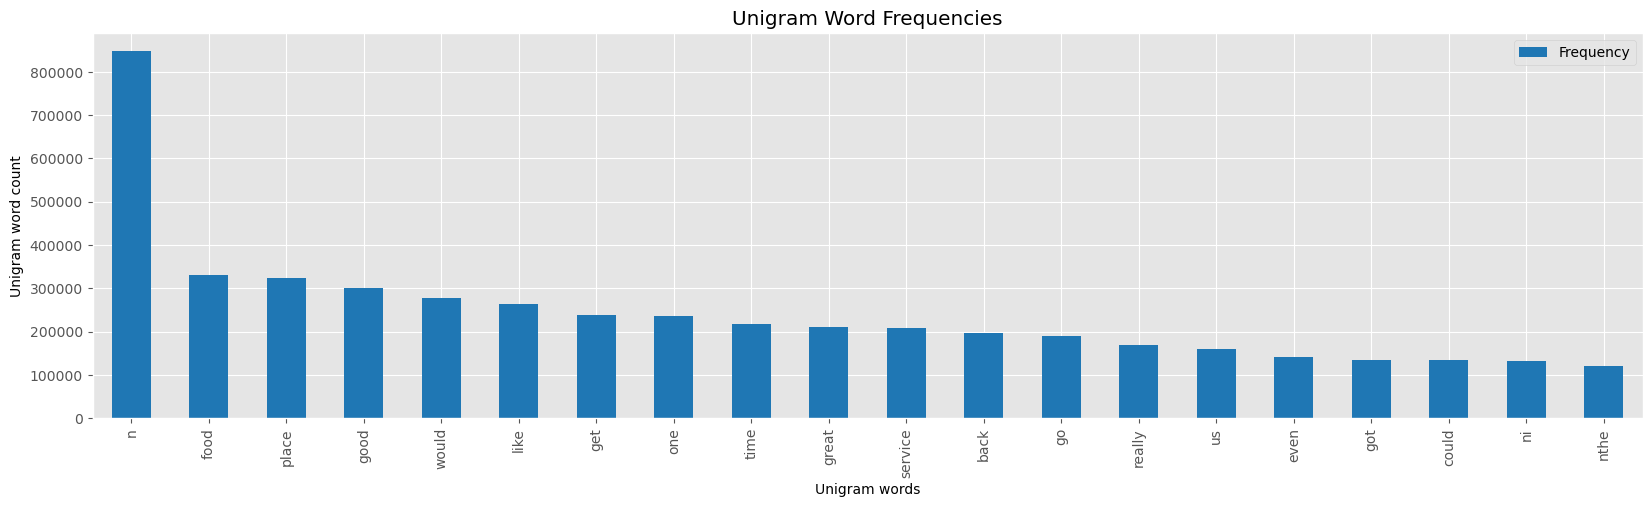

In [23]:
def word_frequencies(text):
    """Function to get word frequencies"""
    word_dict = {}

    for i in text:
        for j in i.split():
            if j not in word_dict.keys():
                word_dict[j] = 1
            else:
                word_dict[j] += 1
    cd = sorted(
        word_dict.items(),
        key=operator.itemgetter(1),
        reverse=True
    )
    word_df = pd.DataFrame(
        cd[0:20],
        columns=['Word', 'Frequency'])
    word_df = word_df.set_index('Word')
    return(word_df)

word_df = word_frequencies(train_df_fixed["review"])
fig = word_df.plot.bar(
    rot=90,
    figsize=(20,5),
    color="tab:blue",
    title="Unigram Word Frequencies",
    label = "Word Frequencies"
)
fig.set_xlabel("Unigram words")
fig.set_ylabel("Unigram word count")

# Modelling

### Splitting Training and Validation dataset

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df_fixed.review.values, 
    train_df_fixed.rating.values,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [30]:
estimators = {}
models = {
    # TF-IDF Vectorizer
    "Model with TfidfVectorizer || MultinomialNB": {
        "model": {
            "id": "mnb",
            "name": MultinomialNB()
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer()
        },
        "parameters": {
            'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
            'tfidf__use_idf': [True, False],
            'tfidf__smooth_idf': [True, False],
            'tfidf__sublinear_tf': [True, False],
            'tfidf__norm': [None, 'l1', 'l2'],
            'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
            'mnb__alpha': [0.0, 0.5, 1.0],
            'mnb__fit_prior': [True, False],
            'mnb__force_alpha': [True, False]
        }
    },
    "Model with TfidfVectorizer || LogisticRegression": {
        "model": {
            "id": "log_reg",
            "name": LogisticRegression()
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer()
        },
        "parameters": {
            'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
            'tfidf__use_idf': [True, False],
            'tfidf__smooth_idf': [True, False],
            'tfidf__sublinear_tf': [True, False],
            'tfidf__norm': [None, 'l1', 'l2'],
            'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
            'log_reg__solver': ['lbfgs', 'liblinear', 'newton-cg',
                           'newton-cholesky', 'sag', 'saga'],
            'log_reg__max_iter': [100, 200, 500, 1000],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    "Model with TfidfVectorizer || DecisionTreeClassifier": {
        "model": {
            "id": "dtree",
            "name": DecisionTreeClassifier()
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer()
        },
        "parameters": {
            'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
            'tfidf__use_idf': [True, False],
            'tfidf__smooth_idf': [True, False],
            'tfidf__sublinear_tf': [True, False],
            'tfidf__norm': [None, 'l1', 'l2'],
            'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
            'dtree__criterion': ['gini', 'entropy'],
            'dtree__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000],
            'dtree__min_samples_leaf': [5, 10, 15, 20, 25, 30, 40,
                                        50, 60, 70, 80, 90, 100]
        }
    },
    "Model with TfidfVectorizer || RandomForestClassifier": {
        "model": {
            "id": "rfc",
            "name": RandomForestClassifier()
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer()
        },
        "parameters": {
            'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
            'tfidf__use_idf': [True, False],
            'tfidf__smooth_idf': [True, False],
            'tfidf__sublinear_tf': [True, False],
            'tfidf__norm': [None, 'l1', 'l2'],
            'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
            'rfc__n_estimators': [100, 200, 300, 400, 500, 1000],
            'rfc__criterion': ['gini', 'entropy', 'log_loss'],
            'rfc__min_samples_leaf': [5, 10, 15, 20, 25, 30,
                                      40, 50, 60, 70, 80, 90, 100]
        }
    },
    "Model with TfidfVectorizer || AdaBoostClassifier": {
        "model": {
            "id": "abc",
            "name": AdaBoostClassifier()
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer()
        },
                "parameters": {
            'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
            'tfidf__use_idf': [True, False],
            'tfidf__smooth_idf': [True, False],
            'tfidf__sublinear_tf': [True, False],
            'tfidf__norm': [None, 'l1', 'l2'],
            'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
            'abc__n_estimators': [100, 200, 300, 400, 500, 1000],
            'abc__algorithm': ['SAMME', 'SAMME.R']
        }
    },
    # Count vectorizer
    "Model with CountVectorizer || MultinomialNB": {
        "model": {
            "id": "mnb",
            "name": MultinomialNB()
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer()
        },
        "parameters": {
            'cv__ngram_range': [(1,1), (1,2), (2,2)],
            'cv__analyzer': ['word', 'char', 'char_wb'],
            'cv__max_features': [100, 200, 500, 1000, 3000, 5000],
            'mnb__alpha': [0.0, 0.5, 1.0],
            'mnb__fit_prior': [True, False],
            'mnb__force_alpha': [True, False]
        }
    },
    "Model with CountVectorizer || LogisticRegression": {
        "model": {
            "id": "log_reg",
            "name": LogisticRegression()
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer()
        },
        "parameters": {
            'cv__ngram_range': [(1,1), (1,2), (2,2)],
            'cv__analyzer': ['word', 'char', 'char_wb'],
            'cv__max_features': [100, 200, 500, 1000, 3000, 5000],
            'log_reg__solver': ['lbfgs', 'liblinear', 'newton-cg',
                           'sag', 'saga'],
            'log_reg__max_iter': [100, 200, 500, 1000],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    "Model with CountVectorizer || DecisionTreeClassifier": {
        "model": {
            "id": "dtree",
            "name": DecisionTreeClassifier()
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer()
        },
        "parameters": {
            'cv__ngram_range': [(1,1), (1,2), (2,2)],
            'cv__analyzer': ['word', 'char', 'char_wb'],
            'cv__max_features': [100, 200, 500, 1000, 3000, 5000],
            'dtree__criterion': ['gini', 'entropy'],
            'dtree__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000],
            'dtree__min_samples_leaf': [5, 10, 15, 20, 25, 30, 40,
                                        50, 60, 70, 80, 90, 100]
        }
    },
    "Model with CountVectorizer || RandomForestClassifier": {
        "model": {
            "id": "rfc",
            "name": RandomForestClassifier()
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer()
        },
        "parameters": {
            'cv__ngram_range': [(1,1), (1,2), (2,2)],
            'cv__analyzer': ['word', 'char', 'char_wb'],
            'cv__max_features': [100, 200, 500, 1000, 3000, 5000],
            'rfc__n_estimators': [100, 200, 300, 400, 500, 1000],
            'rfc__criterion': ['gini', 'entropy', 'log_loss'],
            'rfc__min_samples_leaf': [5, 10, 15, 20, 25, 30,
                                      40, 50, 60, 70, 80, 90, 100]
        }
    },
    "Model with CountVectorizer || AdaBoostClassifier": {
        "model": {
            "id": "abc",
            "name": AdaBoostClassifier()
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer()
        },
        "parameters": {
            'cv__ngram_range': [(1,1), (1,2), (2,2)],
            'cv__analyzer': ['word', 'char', 'char_wb'],
            'cv__max_features': [100, 200, 500, 1000, 3000, 5000],
            'abc__n_estimators': [100, 200, 300, 400, 500, 1000],
            'abc__algorithm': ['SAMME', 'SAMME.R']
        }
    }
}

# Uncomment below line to run RandomizedSearchCV to find best model with Grid Search.
# It took around 15hrs with n_jobs=7 on Mac M2 chip.
model = {}

for model in models:
    print(f"Generating {model}")
    print(f"Time: {time.time()}")
    pipeline = Pipeline(
        steps=[
            (models[model]['vectorizer']['id'], models[model]['vectorizer']['name']),
            (models[model]['model']['id'], models[model]['model']['name'])
        ]
    )
    print(pipeline)
    estimator = RandomizedSearchCV(
        pipeline,
        models[model]['parameters'],
        scoring='accuracy',
        cv=5,
        n_jobs=7,
        verbose=4,
        n_iter=25
    )
    estimator.fit(X_train, y_train)
    print(estimator.best_params_)
    estimators[model] = estimator

Generating Model with CountVectorizer || MultinomialNB
Time: 1702000409.123435
Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.786 total time=   9.4s
[CV 3/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.781 total time=  36.6s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.785 total time=   9.4s
[CV 4/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.784 total time=  36.5s
[CV 3/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.787 total time=   9.5s
[CV 5/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.781 total time=  36.5s
[CV 4/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.790 total time=   9.5s
[CV 1/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False;, sco

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


[CV 5/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.774 total time= 1.4min
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=500, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.777 total time= 1.4min
[CV 3/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.773 total time=  51.0s
[CV 5/5] END cv__analyzer=char_wb, cv__max_features=500, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.774 total time= 1.4min


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


[CV 2/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.778 total time=  50.9s
[CV 5/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.774 total time=  51.1s
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.785 total time=  46.8s
[CV 1/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.818 total time=  35.7s
[CV 5/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.819 total time=  34.5s
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=F

[CV 2/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.864 total time=  46.0s
[CV 4/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True;, score=0.866 total time=  45.6s
[CV 2/5] END cv__analyzer=char, cv__max_features=500, cv__ngram_range=(2, 2), mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True;, score=0.785 total time=  36.6s
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.736 total time= 1.4min
[CV 1/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.692 total time=  39.3s
[CV 1/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, 

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5] END cv__analyzer=word, cv__max_features=500, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.829 total time=  47.3s
[CV 3/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.645 total time=  39.9s
[CV 5/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.866 total time=  46.5s
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.778 total time= 1.4min
[CV 1/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.865 total time=  42.1s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.773 total time= 1.4min
[CV 2/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.864 total time=  43.7s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5] END cv__analyzer=char, cv__max_features=100, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.707 total time=  35.9s
[CV 3/5] END cv__analyzer=char, cv__max_features=100, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.708 total time=  35.9s
[CV 4/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False;, score=0.866 total time=  47.0s
[CV 1/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.864 total time=  43.7s
[CV 3/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True;, score=0.864 total time=  45.1s
[CV 5/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=False

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=500, log_reg__penalty=l1, log_reg__solver=newton-cg;, score=nan total time=  28.4s
[CV 4/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), log_reg__max_iter=200, log_reg__penalty=elasticnet, log_reg__solver=saga;, score=nan total time=  30.2s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=500, log_reg__penalty=l1, log_reg__solver=newton-cg;, score=nan total time=  28.3s
[CV 2/5] END cv__analyzer=char, cv__max_features=500, cv__ngram_range=(2, 2), log_reg__max_iter=200, log_reg__penalty=elasticnet, log_reg__solver=lbfgs;, score=nan total time=  28.3s
[CV 1/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.692 total time=  36.8s
[CV 1/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=500, log_reg__penalty=l1, log_reg__solver=newton-cg;, score=nan total time=  28.4s
[CV 3/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), log_reg__max_iter=200, log_reg__penalty=elasticnet, log_reg__solver=saga;, score=nan total time=  30.2s
[CV 5/5] END cv__analyzer=char, cv__max_features=500, cv__ngram_range=(2, 2), log_reg__max_iter=200, log_

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 3/5] END cv__analyzer=char, cv__max_features=500, cv__ngram_range=(2, 2), log_reg__max_iter=500, log_reg__penalty=l2, log_reg__solver=liblinear;, score=0.831 total time= 2.4min
[CV 1/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=l2, log_reg__solver=lbfgs;, score=0.787 total time=  44.9s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 4/5] END cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(1, 2), log_reg__max_iter=100, log_reg__penalty=elasticnet, log_reg__solver=lbfgs;, score=nan total time=  43.4s
[CV 5/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=l2, log_reg__solver=lbfgs;, score=0.790 total time=  44.3s
[CV 1/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(1, 1), log_reg__max_iter=500, log_reg__penalty=None, log_reg__solver=lbfgs;, score=0.647 total time=  20.8s
[CV 1/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(1, 2), log_reg__max_iter=100, log_reg__penalty=None, log_reg__solver=newton-cg;, score=0.784 total time= 1.5min
[CV 2/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(1, 1), log_reg__max_iter=500, log_reg__penalty=None, log_reg__solver=lbfgs;, score=0.651 total time=  20.7s
[CV 2/5] END cv__analyzer=char, cv__max_features=200, cv__ngram_range=(1, 2), log_reg__max_iter=10

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 2), log_reg__max_iter=100, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.738 total time= 1.7min
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 2), log_reg__max_iter=100, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.740 total time= 1.7min
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.735 total time= 1.4min
[CV 4/5] END cv__analyzer=word, cv__max_features=500, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True;, score=0.830 total time=  47.6s
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False;, score=0.650 total time=  40.3s
[CV 4/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True,

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=1000, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.694 total time=  48.4s
[CV 2/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=1000, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.693 total time=  49.3s
[CV 5/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=1000, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.695 total time=  43.7s
[CV 5/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=l1, log_reg__solver=sag;, score=nan total time=  37.0s
[CV 5/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(1, 1), log_reg__max_iter=1000, log_reg__penalty=l1, log_reg__solver=liblinear;, score=0.648 total time= 1.1min
[CV 4/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=None, log_reg__solver=saga;, score=0.825 total time= 1.5min
[CV 4/5] END cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(1, 2), log_reg__max_iter=200, log_reg__penalty=None, log_reg__solver=newton-cg;, score=0.928 total time= 1.5min
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=None, log_reg__solver=saga;, score=0.828 total time= 1.5min
[CV 3/5] END cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(1, 2), log_reg__max_iter=200, log_reg__penalty=None, log_reg__solver=newton-cg;, score=0.927 total time= 1.6min
[CV 1/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 2), log_reg__max_iter=500, log_reg__penalty=elasticnet, log_reg__solver=saga;, score=nan total time= 1.1min
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 2), 

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_val

[CV 3/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(2, 2), log_reg__max_iter=1000, log_reg__penalty=l2, log_reg__solver=newton-cg;, score=0.693 total time=  46.6s
[CV 3/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2), log_reg__max_iter=100, log_reg__penalty=l1, log_reg__solver=sag;, score=nan total time=  37.0s
[CV 1/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(1, 1), log_reg__max_iter=1000, log_reg__penalty=l1, log_reg__solver=liblinear;, score=0.647 total time= 1.0min
[CV 5/5] END cv__analyzer=word, cv__max_features=1000, cv__ngram_range=(2, 2), log_reg__max_iter=200, log_reg__penalty=l1, log_reg__solver=lbfgs;, score=nan total time=  32.1s
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 1), log_reg__max_iter=200, log_reg__penalty=elasticnet, log_reg__solver=sag;, score=nan total time=  31.4s
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 1), log_reg__max

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=10, dtree__min_samples_leaf=60;, score=0.563 total time=  37.6s
[CV 2/5] END cv__analyzer=word, cv__max_features=100, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=30, dtree__min_samples_leaf=15;, score=0.619 total time=  36.9s


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=10, dtree__min_samples_leaf=60;, score=0.557 total time=  37.0s
[CV 3/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=5, dtree__min_samples_leaf=15;, score=0.663 total time=  44.2s
[CV 1/5] END cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=10, dtree__min_samples_leaf=60;, score=0.560 total time=  37.6s
[CV 4/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=5, dtree__min_samples_leaf=15;, score=0.670 total time=  44.3s
[CV 1/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=5, dtree__min_samples_leaf=15;, score=0.665 total time=  44.5s
[CV 3/5] END cv__analyzer=word, cv__max_features=100, cv__ngram_range=(2,

[CV 1/5] END cv__analyzer=word, cv__max_features=1000, cv__ngram_range=(1, 2), dtree__criterion=gini, dtree__max_depth=6, dtree__min_samples_leaf=30;, score=0.713 total time=  50.3s
[CV 4/5] END cv__analyzer=word, cv__max_features=1000, cv__ngram_range=(1, 2), dtree__criterion=gini, dtree__max_depth=6, dtree__min_samples_leaf=30;, score=0.714 total time=  48.6s
[CV 1/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), dtree__criterion=gini, dtree__max_depth=4, dtree__min_samples_leaf=50;, score=0.705 total time=  10.4s
[CV 2/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), dtree__criterion=gini, dtree__max_depth=4, dtree__min_samples_leaf=50;, score=0.702 total time=  10.4s
[CV 5/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 1), dtree__criterion=gini, dtree__max_depth=4, dtree__min_samples_leaf=50;, score=0.704 total time=  10.2s
[CV 5/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(2, 2), dtree__crit

[CV 2/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 2), dtree__criterion=entropy, dtree__max_depth=4, dtree__min_samples_leaf=5;, score=0.627 total time= 1.4min
[CV 2/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=8, dtree__min_samples_leaf=50;, score=0.703 total time=  56.4s
[CV 5/5] END cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(1, 1), dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=25;, score=0.762 total time=  18.4s
[CV 1/5] END cv__analyzer=word, cv__max_features=100, cv__ngram_range=(1, 1), dtree__criterion=entropy, dtree__max_depth=50, dtree__min_samples_leaf=90;, score=0.751 total time=  19.7s
[CV 3/5] END cv__analyzer=word, cv__max_features=100, cv__ngram_range=(1, 1), dtree__criterion=entropy, dtree__max_depth=50, dtree__min_samples_leaf=90;, score=0.750 total time=  20.3s
[CV 5/5] END cv__analyzer=word, cv__max_features=100, cv__ngram_range=(1, 1)

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(1, 2), dtree__criterion=entropy, dtree__max_depth=1000, dtree__min_samples_leaf=100;, score=0.731 total time= 3.4min
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2), dtree__criterion=gini, dtree__max_depth=15, dtree__min_samples_leaf=10;, score=0.724 total time= 3.7min
[CV 3/5] END cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(2, 2), dtree__criterion=entropy, dtree__max_depth=40, dtree__min_samples_leaf=20;, score=0.640 total time=  44.7s
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(2, 2), dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=5;, score=0.707 total time= 7.4min
[CV 2/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2), dtree__criterion=entropy, dtree__max_depth=12, dtree__min_samples_leaf=15;, score=0.721 total time= 3.0min
[CV 1/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_

[CV 3/5] END cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(1, 2), dtree__criterion=gini, dtree__max_depth=6, dtree__min_samples_leaf=30;, score=0.650 total time= 1.5min
[CV 2/5] END cv__analyzer=word, cv__max_features=200, cv__ngram_range=(1, 2), rfc__criterion=gini, rfc__min_samples_leaf=20, rfc__n_estimators=200;, score=0.804 total time= 9.6min
[CV 3/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(1, 2), rfc__criterion=gini, rfc__min_samples_leaf=25, rfc__n_estimators=300;, score=0.794 total time=50.9min
[CV 4/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 2), rfc__criterion=entropy, rfc__min_samples_leaf=50, rfc__n_estimators=1000;, score=0.794 total time=109.8min
[CV 3/5] END cv__analyzer=char_wb, cv__max_features=5000, cv__ngram_range=(1, 2), rfc__criterion=entropy, rfc__min_samples_leaf=30, rfc__n_estimators=100;, score=0.791 total time=16.2min
[CV 2/5] END cv__analyzer=char, cv__max_features=5000, cv__ngram_range=(2, 2), 

[CV 1/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), rfc__criterion=gini, rfc__min_samples_leaf=90, rfc__n_estimators=400;, score=0.788 total time=25.1min
[CV 3/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(1, 1), rfc__criterion=entropy, rfc__min_samples_leaf=80, rfc__n_estimators=1000;, score=0.656 total time=51.3min
[CV 5/5] END cv__analyzer=char, cv__max_features=1000, cv__ngram_range=(2, 2), rfc__criterion=log_loss, rfc__min_samples_leaf=100, rfc__n_estimators=1000;, score=0.788 total time=58.0min
[CV 1/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(1, 2), rfc__criterion=gini, rfc__min_samples_leaf=60, rfc__n_estimators=300;, score=0.789 total time=29.9min
[CV 3/5] END cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(2, 2), rfc__criterion=gini, rfc__min_samples_leaf=15, rfc__n_estimators=500;, score=0.800 total time=98.4min
[CV 4/5] END cv__analyzer=char, cv__max_features=3000, cv__ngram_range=(2, 2), rfc

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END abc__algorithm=SAMME, abc__n_estimators=200, cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(2, 2);, score=0.637 total time= 1.0min
[CV 1/5] END abc__algorithm=SAMME.R, abc__n_estimators=300, cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2);, score=0.766 total time=10.6min
[CV 4/5] END abc__algorithm=SAMME, abc__n_estimators=200, cv__analyzer=word, cv__max_features=5000, cv__ngram_range=(2, 2);, score=0.639 total time= 1.0min
[CV 2/5] END abc__algorithm=SAMME.R, abc__n_estimators=300, cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2);, score=0.769 total time=10.6min
[CV 3/5] END abc__algorithm=SAMME.R, abc__n_estimators=300, cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2);, score=0.766 total time=10.6min
[CV 5/5] END abc__algorithm=SAMME.R, abc__n_estimators=300, cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2);, score=0.765 total time=10.6min
[CV 3/5] END abc__algorithm=SAMME, abc__n_estima

[CV 3/5] END abc__algorithm=SAMME.R, abc__n_estimators=300, cv__analyzer=word, cv__max_features=500, cv__ngram_range=(2, 2);, score=0.741 total time= 1.1min
[CV 4/5] END abc__algorithm=SAMME, abc__n_estimators=300, cv__analyzer=word, cv__max_features=3000, cv__ngram_range=(1, 1);, score=0.844 total time= 2.9min
[CV 1/5] END abc__algorithm=SAMME, abc__n_estimators=300, cv__analyzer=char, cv__max_features=500, cv__ngram_range=(2, 2);, score=0.803 total time=10.1min
[CV 1/5] END abc__algorithm=SAMME, abc__n_estimators=200, cv__analyzer=word, cv__max_features=100, cv__ngram_range=(2, 2);, score=0.613 total time=  53.4s
[CV 3/5] END abc__algorithm=SAMME, abc__n_estimators=200, cv__analyzer=word, cv__max_features=100, cv__ngram_range=(2, 2);, score=0.613 total time=  54.1s
[CV 1/5] END abc__algorithm=SAMME, abc__n_estimators=300, cv__analyzer=char_wb, cv__max_features=100, cv__ngram_range=(2, 2);, score=0.722 total time= 5.7min
[CV 5/5] END abc__algorithm=SAMME, abc__n_estimators=300, cv__an

[CV 2/5] END abc__algorithm=SAMME.R, abc__n_estimators=100, cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2);, score=0.794 total time= 4.0min
[CV 4/5] END abc__algorithm=SAMME.R, abc__n_estimators=100, cv__analyzer=char_wb, cv__max_features=1000, cv__ngram_range=(2, 2);, score=0.793 total time= 3.8min
[CV 4/5] END abc__algorithm=SAMME.R, abc__n_estimators=200, cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2);, score=0.811 total time= 8.6min
[CV 5/5] END abc__algorithm=SAMME.R, abc__n_estimators=500, cv__analyzer=char_wb, cv__max_features=200, cv__ngram_range=(1, 2);, score=0.773 total time=15.9min
[CV 4/5] END abc__algorithm=SAMME.R, abc__n_estimators=400, cv__analyzer=char, cv__max_features=5000, cv__ngram_range=(1, 1);, score=0.656 total time= 2.7min
[CV 1/5] END abc__algorithm=SAMME.R, abc__n_estimators=200, cv__analyzer=char_wb, cv__max_features=3000, cv__ngram_range=(1, 2);, score=0.808 total time= 8.6min
[CV 5/5] END abc__algorithm=SAMME.R, a

In [43]:
estimators = {}

# Below are models with params which RandomizedSearchCV found from above cell.
# Have hardcoded best params here for faster notebook runs.
best_models = {
    # TF-IDF Vectorizer
    "Model with TfidfVectorizer || MultinomialNB": {
        "model": {
            "id": "mnb",
            "name": MultinomialNB(
                force_alpha=True,
                fit_prior=False,
                alpha=0.0
            )
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer(
                use_idf=True,
                sublinear_tf=True,
                smooth_idf=True,
                norm='l1',
                ngram_range=(1, 2),
                max_features=5000
            )
        }
    },
    "Model with TfidfVectorizer || LogisticRegression": {
        "model": {
            "id": "log_reg",
            "name": LogisticRegression(
                solver="newton-cholesky",
                penalty=None,
                max_iter=500
            )
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer(
                use_idf=False,
                sublinear_tf=False,
                smooth_idf=True,
                norm='l1',
                ngram_range=(1, 2),
                max_features=3000
            )
        }
    },
    "Model with TfidfVectorizer || DecisionTreeClassifier": {
        "model": {
            "id": "dtree",
            "name": DecisionTreeClassifier(
                min_samples_leaf=30,
                max_depth=70,
                criterion="gini"
            )
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer(
                use_idf=False,
                sublinear_tf=False,
                smooth_idf=False,
                norm='l2',
                ngram_range=(1, 1),
                max_features=3000
            )
        }
    },
    "Model with TfidfVectorizer || RandomForestClassifier": {
        "model": {
            "id": "rfc",
            "name": RandomForestClassifier(
                n_estimators=300,
                min_samples_leaf=20,
                criterion="entropy"
            )
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer(
                use_idf=True,
                sublinear_tf=False,
                smooth_idf=False,
                norm='l2',
                ngram_range=(1, 1),
                max_features=3000
            )
        }
    },
    "Model with TfidfVectorizer || AdaBoostClassifier": {
        "model": {
            "id": "abc",
            "name": AdaBoostClassifier(
                n_estimators=1000,
                algorithm='SAMME.R'
            )
        },
        "vectorizer": {
            "id": "tfidf",
            "name": TfidfVectorizer(
                use_idf=False,
                sublinear_tf=True,
                smooth_idf=True,
                norm='l1',
                ngram_range=(1, 1),
                max_features=3000
            )
        }
    },
    # Count vectorizer
    "Model with CountVectorizer || MultinomialNB": {
        "model": {
            "id": "mnb",
            "name": MultinomialNB(
                force_alpha=False,
                fit_prior=False,
                alpha=0.0
            )
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer(
                ngram_range=(1, 2),
                max_features=3000,
                analyzer='word'
            )
        }
    },
    "Model with CountVectorizer || LogisticRegression": {
        "model": {
            "id": "log_reg",
            "name": LogisticRegression(
                solver='newton-cg',
                penalty=None,
                max_iter=200
            )
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer(
                ngram_range=(1, 2),
                max_features=5000,
                analyzer='word'
            )
        }
    },
    "Model with CountVectorizer || DecisionTreeClassifier": {
        "model": {
            "id": "dtree",
            "name": DecisionTreeClassifier(
                min_samples_leaf=20,
                max_depth=100,
                criterion='gini'
            )
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer(
                ngram_range=(1, 2),
                max_features=500,
                analyzer='word'
            )
        }
    },
    "Model with CountVectorizer || RandomForestClassifier": {
        "model": {
            "id": "rfc",
            "name": RandomForestClassifier(
                n_estimators=200,
                min_samples_leaf=90,
                criterion='log_loss',
            )
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer(
                ngram_range=(1, 2),
                max_features=1000,
                analyzer='word'
            )
        }
    },
    "Model with CountVectorizer || AdaBoostClassifier": {
        "model": {
            "id": "abc",
            "name": AdaBoostClassifier(
                n_estimators=300,
                algorithm='SAMME.R'
            )
        },
        "vectorizer": {
            "id": "cv",
            "name": CountVectorizer(
                ngram_range=(1, 2),
                max_features=1000,
                analyzer='word'
            )
        }
    }
}

for model in best_models:
    print(f"Generating {model}")
    pipeline = Pipeline(
        steps=[
            (best_models[model]['vectorizer']['id'], best_models[model]['vectorizer']['name']),
            (best_models[model]['model']['id'], best_models[model]['model']['name'])
        ]
    )
    print(pipeline)
    estimator = RandomizedSearchCV(
        pipeline,
        {},
        scoring='accuracy',
        cv=5,
        n_jobs=7,
        verbose=4
    )
    estimator.fit(X_train, y_train)
    print(estimator.best_params_)
    estimators[model] = estimator

Generating Model with TfidfVectorizer || MultinomialNB
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 norm='l1', sublinear_tf=True)),
                ('mnb',
                 MultinomialNB(alpha=0.0, fit_prior=False, force_alpha=True))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



{}
Generating Model with TfidfVectorizer || LogisticRegression
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2),
                                 norm='l1', use_idf=False)),
                ('log_reg',
                 LogisticRegression(max_iter=500, penalty=None,
                                    solver='newton-cholesky'))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 5/5] END ..................................., score=0.892 total time=  45.6s
[CV 2/5] END ..................................., score=0.919 total time= 1.5min
[CV 2/5] END ..................................., score=0.891 total time=  45.6s
[CV 4/5] END ..................................., score=0.923 total time= 1.5min
{}
Generating Model with TfidfVectorizer || DecisionTreeClassifier
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3000, smooth_idf=False,
                                 use_idf=False)),
                ('dtree',
                 DecisionTreeClassifier(max_depth=70, min_samples_leaf=30))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 3/5] END ..................................., score=0.888 total time=  45.2s
[CV 1/5] END ..................................., score=0.890 total time=  46.0s
[CV 5/5] END ..................................., score=0.920 total time= 1.5min
{}
Generating Model with TfidfVectorizer || RandomForestClassifier
Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=3000, smooth_idf=False)),
                ('rfc',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_leaf=20,
                                        n_estimators=300))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 1/5] END ..................................., score=0.815 total time= 2.2min
[CV 1/5] END ..................................., score=0.921 total time= 1.5min
[CV 3/5] END ..................................., score=0.813 total time= 2.2min
[CV 1/5] END ..................................., score=0.877 total time=11.0min
[CV 2/5] END ..................................., score=0.813 total time= 2.2min
[CV 2/5] END ..................................., score=0.877 total time=11.1min
[CV 5/5] END ..................................., score=0.816 total time= 2.3min
[CV 5/5] END ..................................., score=0.879 total time=11.2min
[CV 4/5] END ..................................., score=0.892 total time=  46.4s
[CV 3/5] END ..................................., score=0.919 total time= 1.5min
[CV 4/5] END ..................................., score=0.815 total time= 2.3min
[CV 4/5] END ..................................., score=0.879 total time=11.0min
[CV 3/5] END ...............

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 3/5] END ..................................., score=0.907 total time=28.8min
[CV 4/5] END ..................................., score=0.909 total time=29.0min
[CV 2/5] END ..................................., score=0.907 total time=29.0min
[CV 1/5] END ..................................., score=0.909 total time=29.1min
[CV 5/5] END ..................................., score=0.909 total time=29.4min
{}
Generating Model with CountVectorizer || MultinomialNB
Pipeline(steps=[('cv', CountVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('mnb',
                 MultinomialNB(alpha=0.0, fit_prior=False, force_alpha=False))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naiv

{}
Generating Model with CountVectorizer || LogisticRegression
Pipeline(steps=[('cv', CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('log_reg',
                 LogisticRegression(max_iter=200, penalty=None,
                                    solver='newton-cg'))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END ..................................., score=0.864 total time=  45.1s
[CV 4/5] END ..................................., score=0.928 total time= 1.4min
[CV 3/5] END ..................................., score=0.865 total time=  44.8s
[CV 3/5] END ..................................., score=0.927 total time= 1.5min
[CV 1/5] END ..................................., score=0.865 total time=  45.2s
[CV 4/5] END ..................................., score=0.866 total time=  45.9s
[CV 5/5] END ..................................., score=0.928 total time= 1.5min


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................................., score=0.867 total time=  44.8s
[CV 2/5] END ..................................., score=0.925 total time=10.1min


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................................., score=0.928 total time=10.7min
{}
Generating Model with CountVectorizer || DecisionTreeClassifier
Pipeline(steps=[('cv', CountVectorizer(max_features=500, ngram_range=(1, 2))),
                ('dtree',
                 DecisionTreeClassifier(max_depth=100, min_samples_leaf=20))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



{}
Generating Model with CountVectorizer || RandomForestClassifier
Pipeline(steps=[('cv', CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('rfc',
                 RandomForestClassifier(criterion='log_loss',
                                        min_samples_leaf=90,
                                        n_estimators=200))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 1/5] END ..................................., score=0.808 total time= 2.1min
[CV 5/5] END ..................................., score=0.808 total time= 2.1min
[CV 5/5] END ..................................., score=0.857 total time= 3.2min
{}
Generating Model with CountVectorizer || AdaBoostClassifier
Pipeline(steps=[('cv', CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('abc', AdaBoostClassifier(n_estimators=300))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



[CV 3/5] END ..................................., score=0.803 total time= 2.1min
[CV 3/5] END ..................................., score=0.855 total time= 3.1min
[CV 2/5] END ..................................., score=0.804 total time= 2.1min
[CV 2/5] END ..................................., score=0.855 total time= 3.2min
{}
[CV 1/5] END ..................................., score=0.855 total time= 3.2min
[CV 1/5] END ..................................., score=0.887 total time= 2.6min
[CV 4/5] END ..................................., score=0.887 total time= 2.6min
[CV 2/5] END ..................................., score=0.884 total time= 2.7min
[CV 4/5] END ..................................., score=0.806 total time= 2.2min
[CV 4/5] END ..................................., score=0.856 total time= 3.2min
[CV 3/5] END ..................................., score=0.887 total time= 2.7min
[CV 5/5] END ..................................., score=0.888 total time= 2.7min


In [44]:
def evaluation(model, title):
    """Function to evaluate performance of a model
    """
    train_predict = model.predict(X_train)
    valid_predict = model.predict(X_valid)
    training_accuracy = accuracy_score(train_predict, y_train)*100
    test_accuracy = accuracy_score(valid_predict, y_valid)*100
    precision = precision_score(valid_predict, y_valid)*100
    recall = recall_score(valid_predict, y_valid)*100
    
    # Generate Confusion matrix
    cm = confusion_matrix(y_valid, model.predict(X_valid))
    disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
    disp.plot(cmap="Blues", values_format='')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()
    return training_accuracy, test_accuracy, precision, recall


# Evaluation

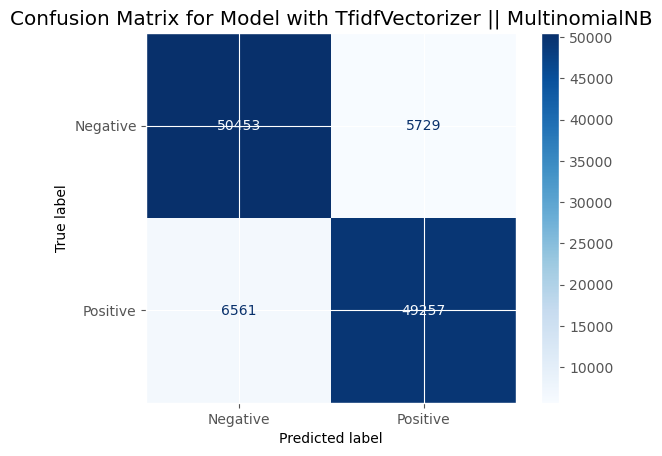

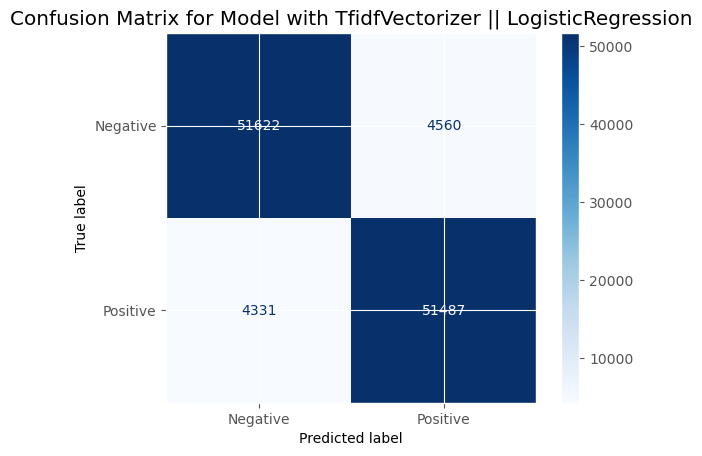

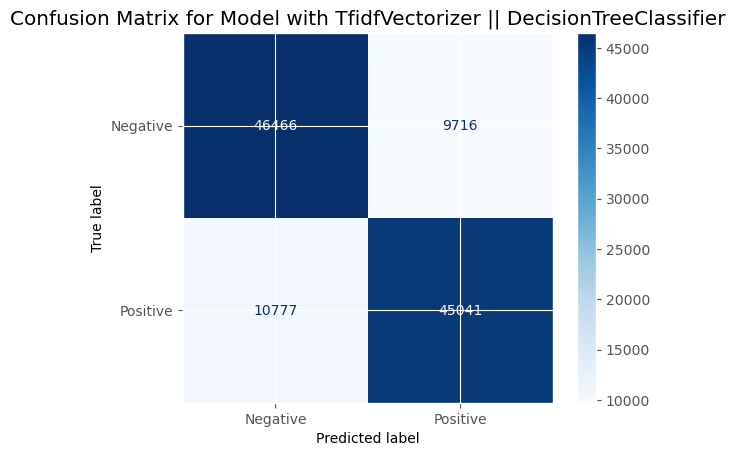

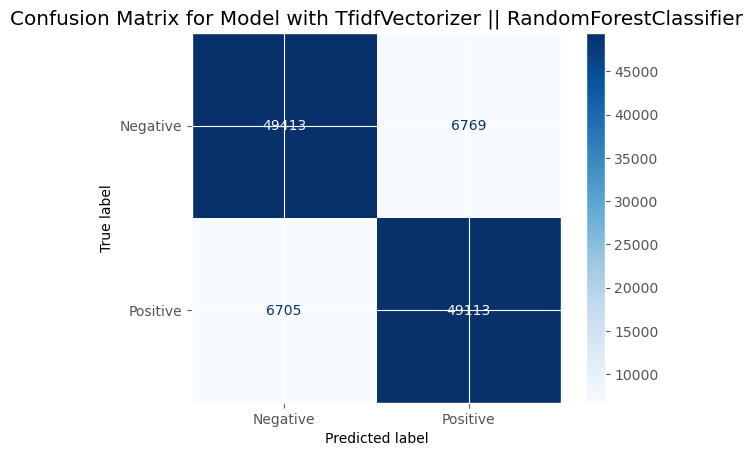

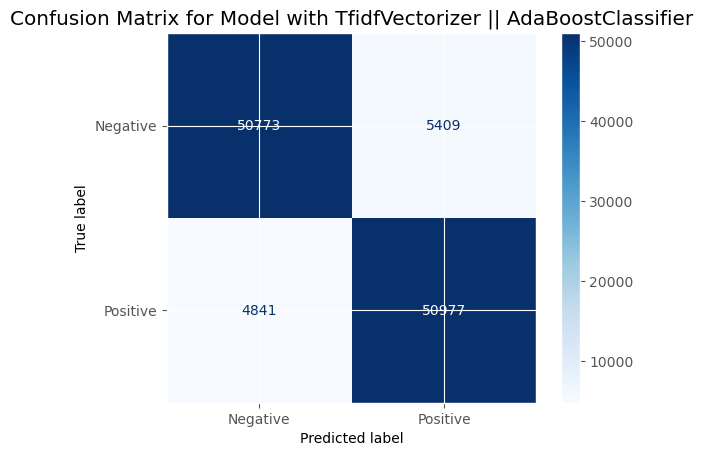

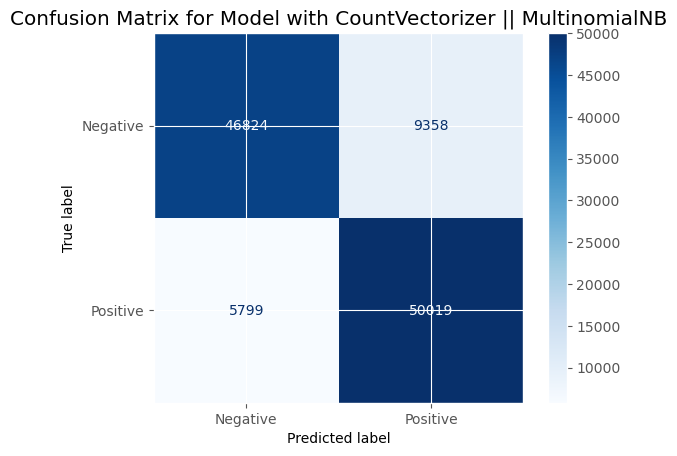

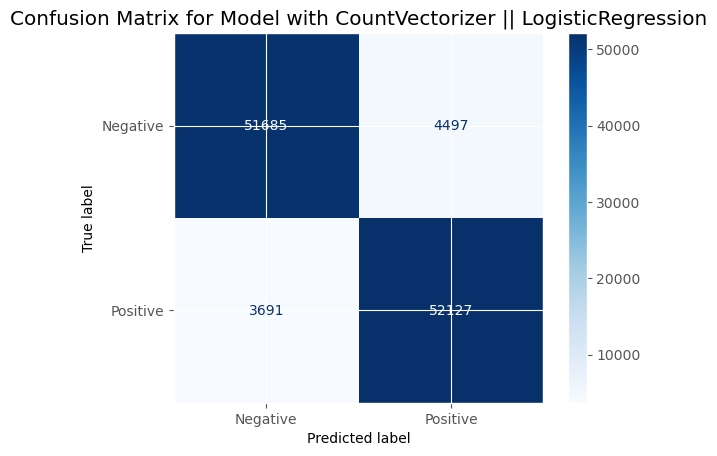

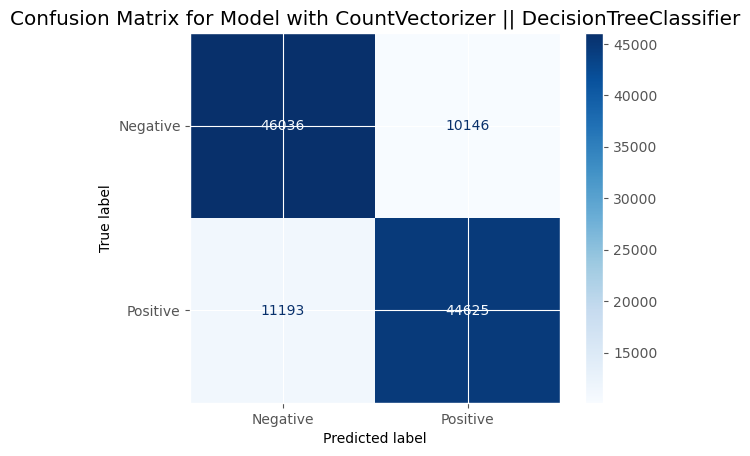

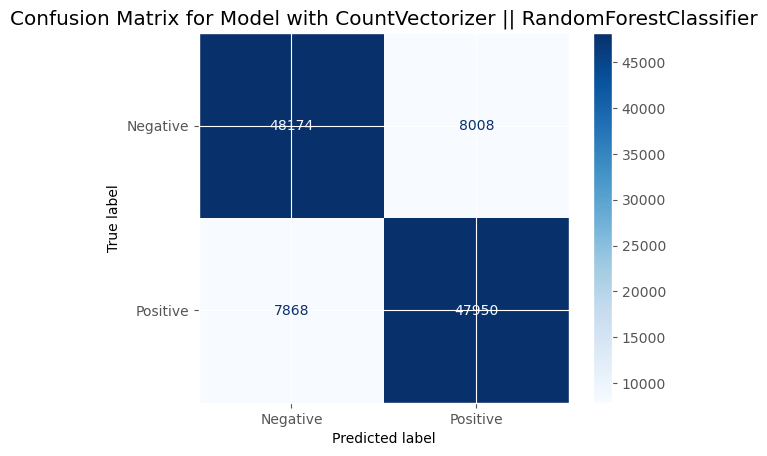

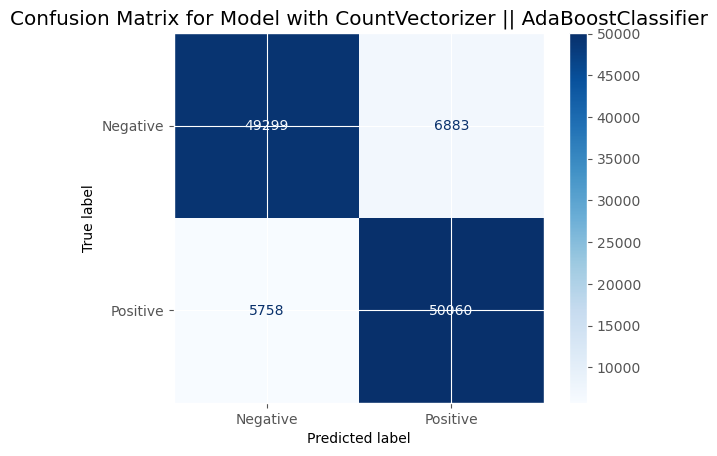

In [45]:
results = {
    'model': [],
    'best_params': [],
    'best_score': []
}


for estimator in estimators:
    results['model'].append(estimator)
    results['best_params'].append(estimators[estimator].best_params_)
    training_score, test_score, precision, recall = evaluation(
        estimators[estimator].best_estimator_,
        estimator
    )
    results['best_score'].append(test_score)

"""
results = pd.DataFrame({
    'model': [';'ty'
    /yy
        'MultinomialNB',
        'LogisticRegression',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'AdaBoostClassifier'
    ], 
    'best_params': [
        mnb_grid.best_params_,
        log_reg_grid.best_params_,
        dtree_grid.best_params_,
        rfc_grid.best_params_,
        abc_grid.best_params_
    ],
    'best_score': [
        mnb_test_score,
        log_reg_test_score,
        dtree_test_score,
        rfc_test_score,
        abc_test_score
    ]}).set_index('model')
"""
results = pd.DataFrame(results).set_index('model')

In [46]:
pd.set_option('max_colwidth', None)
results

,best_params,best_score
model,,
Model with TfidfVectorizer || MultinomialNB,{},89.026786
Model with TfidfVectorizer || LogisticRegression,{},92.061607
Model with TfidfVectorizer || DecisionTreeClassifier,{},81.702679
Model with TfidfVectorizer || RandomForestClassifier,{},87.969643
Model with TfidfVectorizer || AdaBoostClassifier,{},90.848214
Model with CountVectorizer || MultinomialNB,{},86.466964
Model with CountVectorizer || LogisticRegression,{},92.689286
Model with CountVectorizer || DecisionTreeClassifier,{},80.947321
Model with CountVectorizer || RandomForestClassifier,{},85.825000


In [47]:
fig = px.bar(
    data_frame=results,
    x = results.index,
    y = results.best_score,
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    title='Yelp sentiment analysis models performance - Best accuracy!',
)
fig.update_layout(xaxis_title='Models', yaxis_title='Value')

# Next steps for Module 24 Capstone part 2 week.

Right now, LogisticRegressor is performing better with about 93% accuracy on validation dataset. Next steps i would perform is:

* Find performance on test_df.
* Clean up the notebook and move around code blocks appropriately.
* Generate RandomForest and AdaBoostClassifiers with more n_iter's if possible.
* Generate models with CountVectorizer.
* Build a performance graph for various model thats generated.
* Deploy the model on DigitalOcean or any other cloud provider.
